In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms, models
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
path = 'C:\dataset'

In [4]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.ImageFolder(path, transform=transform)

train_size = int(0.74 * len(dataset))
val_size = int(0.10 * len(dataset))
test_size = len(dataset) - train_size - val_size


indices = list(range(len(dataset)))
np.random.shuffle(indices)


train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]


train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

2370 320 514


In [9]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 5)  # Assuming 5 classes for classification
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 32 * 32)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train
num_epochs = 10

train_losses = [] 
train_accuracies = [] 
val_losses = []   
val_accuracies = [] 


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step()
    
    train_losses.append(running_loss / len(train_loader)) 
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)  
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_losses.append(val_loss / len(val_loader))  
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy) 
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_accuracy:.2f}%")


torch.save(model.state_dict(), 'simple_cnn_model.pth')


# Evaluate
model.eval()
test_loss = 0.0
correct = 0
total = 0
test_predictions = []
test_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_predictions.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Epoch [1/10], Loss: 1.5053, Accuracy: 35.49%
Validation Loss: 1.3245, Accuracy: 44.06%
Epoch [2/10], Loss: 1.2757, Accuracy: 44.39%
Validation Loss: 1.3236, Accuracy: 45.00%
Epoch [3/10], Loss: 1.1963, Accuracy: 50.55%
Validation Loss: 1.2375, Accuracy: 49.38%
Epoch [4/10], Loss: 1.0707, Accuracy: 56.50%
Validation Loss: 1.2601, Accuracy: 54.06%
Epoch [5/10], Loss: 0.9343, Accuracy: 62.70%
Validation Loss: 1.1542, Accuracy: 55.62%
Epoch [6/10], Loss: 0.6737, Accuracy: 75.11%
Validation Loss: 1.2233, Accuracy: 55.31%
Epoch [7/10], Loss: 0.3804, Accuracy: 87.05%
Validation Loss: 1.5462, Accuracy: 53.12%
Epoch [8/10], Loss: 0.1173, Accuracy: 96.33%
Validation Loss: 1.9778, Accuracy: 56.88%
Epoch [9/10], Loss: 0.0859, Accuracy: 97.47%
Validation Loss: 2.2975, Accuracy: 54.69%
Epoch [10/10], Loss: 0.0275, Accuracy: 99.49%
Validation Loss: 2.4738, Accuracy: 58.12%
Test Loss: 2.3286, Test Accuracy: 58.75%


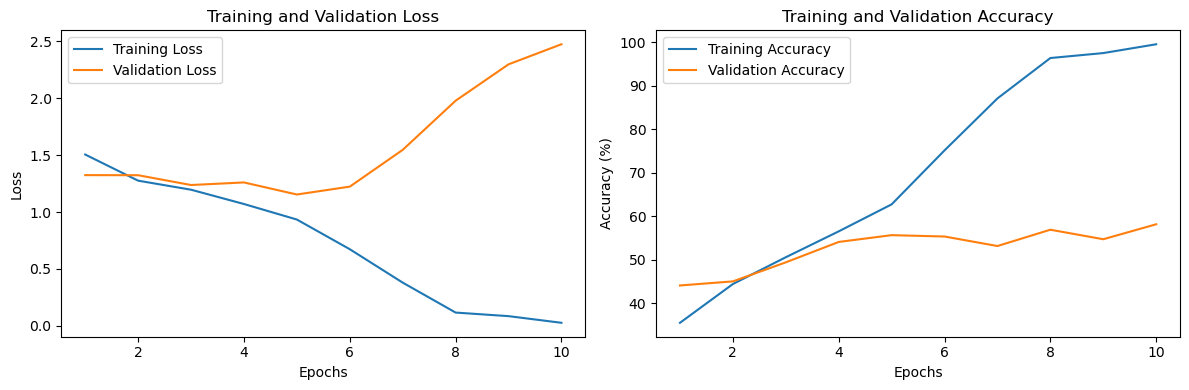

In [11]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


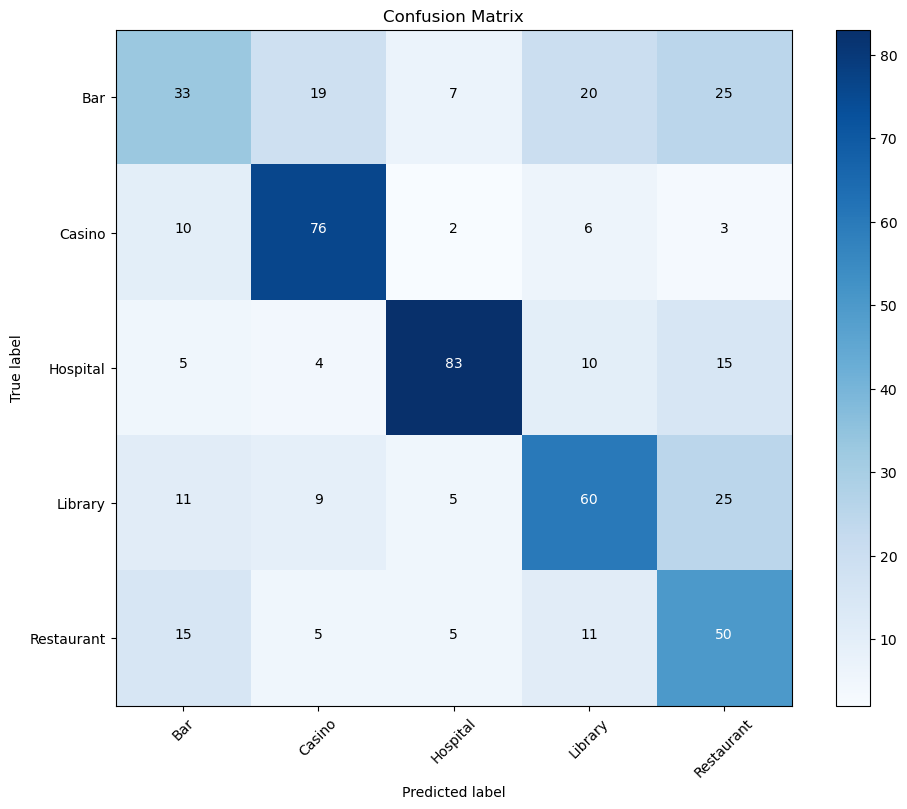

Classification Report:
              precision    recall  f1-score   support

         Bar       0.45      0.32      0.37       104
      Casino       0.67      0.78      0.72        97
    Hospital       0.81      0.71      0.76       117
     Library       0.56      0.55      0.55       110
  Restaurant       0.42      0.58      0.49        86

    accuracy                           0.59       514
   macro avg       0.58      0.59      0.58       514
weighted avg       0.59      0.59      0.58       514



In [12]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

conf_matrix = confusion_matrix(test_labels, test_predictions)
plot_confusion_matrix(conf_matrix, classes=dataset.classes, title='Confusion Matrix')

class_report = classification_report(test_labels, test_predictions, target_names=dataset.classes)
print('Classification Report:')
print(class_report)
